# And

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran.drawing import show_bloq
from typing import *
import numpy as np

## `And`
A two-bit 'and' operation.

#### Parameters
 - `cv1`: Whether the first bit is a positive control.
 - `cv2`: Whether the second bit is a positive control. 

Registers:
 - ctrl: A two-bit control register.
 - (right) target: The output bit.

#### References
(Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity)[https://arxiv.org/abs/1805.03662]. Babbush et. al. 2018. Section III.A. and Fig. 4. (Verifying Measurement Based Uncomputation)[https://algassert.com/post/1903]. Gidney, C. 2019.


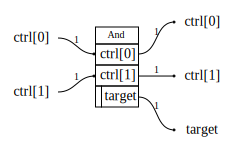

In [2]:
from qualtran.bloqs.and_bloq import And

bloq = And()
show_bloq(bloq)

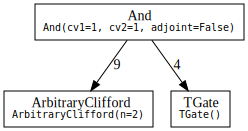

In [3]:
from qualtran.resource_counting import get_bloq_counts_graph, GraphvizCounts, SympySymbolAllocator
import attrs

graph, sigma = get_bloq_counts_graph(bloq)
GraphvizCounts(graph).get_svg()

### Test `adjoint`

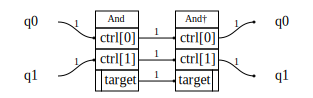

In [4]:
bb = BloqBuilder()
q0 = bb.add_register('q0', 1)
q1 = bb.add_register('q1', 1)
qs, trg = bb.add(And(), ctrl=[q0, q1])
qs = bb.add(And(adjoint=True), ctrl=qs, target=trg)
cbloq = bb.finalize(q0=qs[0], q1=qs[1])

show_bloq(cbloq)

In [5]:
mat = cbloq.tensor_contract()
np.testing.assert_allclose(np.eye(4), mat)
mat

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

## `MultiAnd`
A many-bit (multi-control) 'and' operation.

#### Parameters
 - `cvs`: A tuple of control variable settings. Each entry specifies whether that control line is a "positive" control (`cv[i]=1`) or a "negative" control `0`. 

Registers:
 - ctrl: An n-bit control register.
 - (right) An `n-2` bit junk register to be cleaned up by the inverse operation.
 - (right) target: The output bit.

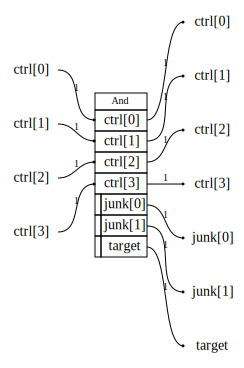

In [6]:
from qualtran.bloqs.and_bloq import MultiAnd

bloq = MultiAnd(cvs=(1, 1, 1, 1))
show_bloq(bloq)

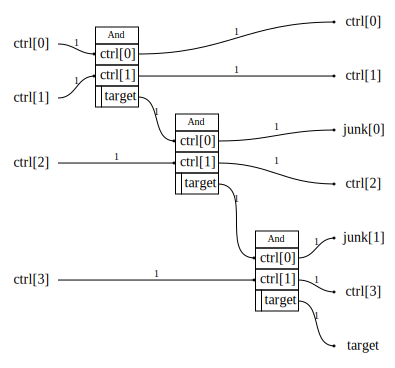

In [7]:
bloq = MultiAnd(cvs=(1, 1, 1, 1))
show_bloq(bloq.decompose_bloq())

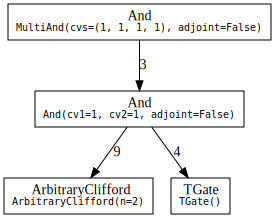

In [8]:
graph, sigma = get_bloq_counts_graph(bloq)
GraphvizCounts(graph).get_svg()

### Testing with states and effects

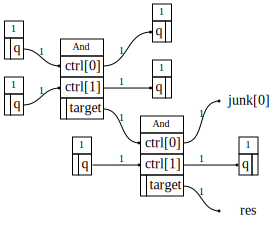

In [9]:
from qualtran.bloqs.basic_gates import OneEffect, OneState, ZeroEffect, ZeroState

state = [ZeroState(), OneState()]
eff = [ZeroEffect(), OneEffect()]

# Experiment with changing the following:
cvs = (1, 1, 1)
ctrl_string = (1, 1, 1)


bb = BloqBuilder()
ctrl_qs = [bb.add(state[c]) for c in ctrl_string]
ctrl_qs, junk, res = bb.add_from(MultiAnd(cvs), ctrl=ctrl_qs)
for c, q in zip(ctrl_string, ctrl_qs):
    bb.add(eff[c], q=q)

cbloq = bb.finalize(junk=junk, res=res)
show_bloq(cbloq)

In [10]:
vec = cbloq.tensor_contract()
junk_i, res_i = np.where(vec.reshape((2, 2)))
res_i

array([1])

In [11]:
should_be = np.all(ctrl_string == cvs)
should_be

True

### MultiAnd Adjoint

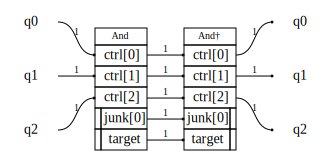

In [12]:
bb = BloqBuilder()
q0 = bb.add_register('q0', 1)
q1 = bb.add_register('q1', 1)
q2 = bb.add_register('q2', 1)

qs, junk, trg = bb.add(MultiAnd((1,1,1)), ctrl=[q0, q1, q2])
qs = bb.add(MultiAnd((1,1,1), adjoint=True), ctrl=qs, target=trg, junk=junk)

cbloq = bb.finalize(q0=qs[0], q1=qs[1], q2=qs[2])

show_bloq(cbloq)

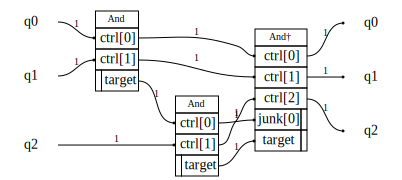

In [13]:
bb = BloqBuilder()
q0 = bb.add_register('q0', 1)
q1 = bb.add_register('q1', 1)
q2 = bb.add_register('q2', 1)

qs, junk, trg = bb.add_from(MultiAnd((1,1,1)), ctrl=[q0, q1, q2])
qs = bb.add(MultiAnd((1,1,1), adjoint=True), ctrl=qs, target=trg, junk=junk)

cbloq = bb.finalize(q0=qs[0], q1=qs[1], q2=qs[2])

show_bloq(cbloq)

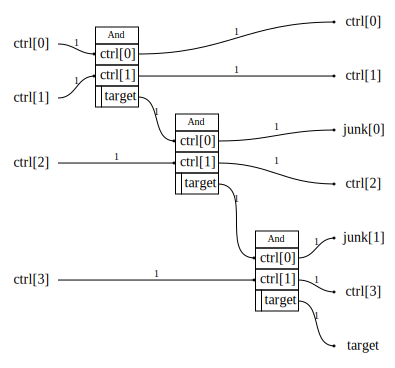

In [14]:
from qualtran.bloqs.and_bloq import MultiAnd
bloq = MultiAnd((1,1,1,1))
show_bloq(bloq.decompose_bloq())

## Classical Simulation

The `And` gate is classical logic, so we can simulate it on discrete bitstrings.

In [15]:
ctrl, out = And().call_classically(ctrl=np.array([1, 1]))
out

1

In [16]:
ctrl = np.array([1,1,1,1])
ctrl, junk, out = MultiAnd((1,1,1,1)).call_classically(ctrl=ctrl)
out

1

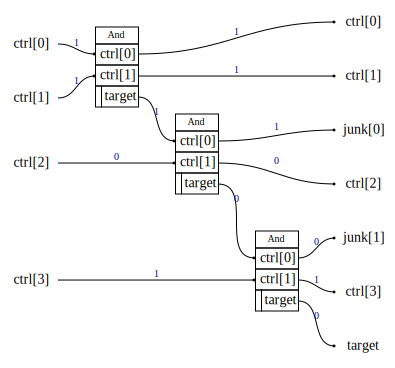

In [17]:
from qualtran.drawing import ClassicalSimGraphDrawer

ClassicalSimGraphDrawer(
    MultiAnd((1,1,1,1)).decompose_bloq(), 
    vals=dict(ctrl=[1,1,0,1])
).get_svg()